# SCC0270 - Redes Neurais e Aprendizado Profundo
## Trabalho Prático 3 - Detecção de bullying em tweets

NOME: Gianluca Capezzuto Sardinha

NUSP: 11876933

---

NOME: Pedro Cavallini

NUSP: 11801007

## Ambiente

**Atenção**: recomenda-se o uso de **GPU** para rodar os modelos de redes neurais abaixo. Se não estiver disponível no seu hardware, sugere-se utilizar um IDE que forneça este recurso gratuitamente, como o **Google Colab**.

Se for utilizar o **Colab**, basta que selecione `Ambiente de execução` no menu horizontal superior, depois selecione a opção `Alterar o tipo de ambiente de execução`, então escolha **GPU** na opção `Acelerador de hardware` e clique em **Salvar**.

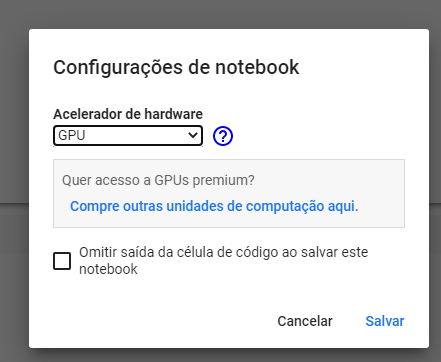

Neste trabalho vamos explorar e aplicar técnicas de Processamento de Linguagem Natural (PLN) para tratar textos (em Inglês) e prepará-los para servir de input em modelos de aprendizado de máquina (ML), com intuito de identificar e classificar tweets com conteúdo de bullying.

As classes são tipos de bullying: *religion*, *age*, *ethnicity*, *gender*, *other_cyberbullying* e *not_cyberbullying*.

Os algoritmos de ML que iremos explorar são: Naive Bayes, LSTM e BERT (Transformers).

A base de dados fornecida contém os textos dos tweets e a classe a eles atribuída.

## Contexto

Você é um cientista de dados que trabalha para uma rede social muito famosa. Você faz parte do departamento de Processamento de Linguagem Natural (PLN) que trata textos em inglês e os prepara para servir de input em modelos de aprendizado de máquina (ML).

Certo dia, um bilionário resolveu comprar a rede social que você trabalha. Mas não contente, Melon Rusk, o novo dono, resolveu dar uma de thanos e demitir metade dos funcionários do seu departamento. Com isso, você e seu colega tiveram que herdar uma tarefa inacabada.

Esses seus colegas, que foram demitidos, estavam trabalhando em um novo sistema de detecção e classificação de mensagens com conteúdo de bullying, onde cada classe representa um tipo de bullying: *religion*, *age*, *ethnicity*, *gender*, *other_cyberbullying* e *not_cyberbullying*.

Porém, seus colegas não prestavam atenção nas aulas e não usaram o git corretamente. O notebook que eles estavam desenvolvendo, que continha os códigos mais atualizados, foram perdidos, restando apenas os resultados e as métricas obtidos.

Para que vocês não sejam demitidos também, Melon Rusk exigiu que vocês continuassem o trabalho de detecção de bullying e espera receber um notebook que funcione, em duas semanas. E mais ainda, ele passou o desafio adicional de fazer melhor do que o seu colega que fora demitido.

Uma boa notícia é que diversos comentários ficaram pelo meio caminho, indicando algumas possíveis maneiras de melhorar os resultados.

## Avaliação

Utilize os conhecimentos obtidos nas aulas do Moacir para fazer um trabalho fenomenal e obter modelos que atinjam as melhores métricas possíveis. As métricas que você obter, serão comparadas com duas outras: uma feita pelo estagiário (valor base), e outra feita pelos seus colegas demitidos (valor referência).

A nota final do trabalho, será dada segundo a fórmula:

> Nota_final = (N_naive + N_lstm + N_bert) / 3
>
> Nota_final *= 10  # pra ficar no padrão USP de 0 a 10

e cada N_i, onde i = {naive, lstm, bert}, é dada segundo a função:

In [1]:
def nota(valor_base, valor_referencia, valor_aluno):
    return np.minimum(1, np.maximum(0, 1 - (valor_referencia - valor_aluno) / (valor_referencia - valor_base)))

Ou seja, estamos avaliando o quanto você consegue fazer cada um dos modelos desempenhar melhor do que o modelo base.

Se para um dado modelo, a sua acurácia ficar menor do que a acurácia base, então sua nota para aquele modelo será 0. E se para um dado modelo, sua acurácia ficar maior do que a acurácia de referência, então sua nota para o modelo será 10.

Nos casos intermediários, sua nota é a porcentagem de melhoria para cada modelo.

A nota final do trabalho é composta pela média aritmética dos três modelos.

No final do notebook, sua nota será calculada automaticamente, mas vale ressaltar que para se tornar oficial, o seu trabalho será corrigido manualmente pelo Professor, PAEs e monitores da disciplina, e a nota final oficial será publicada no moodle.

## Setup

In [2]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
!pip install emoji
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#PyTorch for NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
!pip install transformers
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

# Performance
from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to /home/gian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


<Figure size 432x288 with 0 Axes>

## Preparação dos Dados


In [3]:
# download and unzip the file from a Google Drive repository
!gdown --id 1ue-_eeS2imcSeLiEofh0rzBo3fnyuZ7r
!unzip cyberbullying_tweets.csv.zip

/home/gian/.local/lib/python3.8/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ue-_eeS2imcSeLiEofh0rzBo3fnyuZ7r
To: /home/gian/Documentos/Códigos/6º Semestre/SCC0270/Trabalho 3/cyberbullying_tweets.csv.zip
100%|██████████████████████████████████████| 2.96M/2.96M [00:00<00:00, 6.88MB/s]
Archive:  cyberbullying_tweets.csv.zip
replace cyberbullying_tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# Import into a PandasDataframe 
df = pd.read_csv('cyberbullying_tweets.csv')
print(df.shape)
df.head()

(47692, 2)


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
# rename columns
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [7]:
# check for duplicated rows and eliminate them
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas duplicadas: 0


In [16]:
# Class distribution
print(df.sentiment.value_counts(normalize=True))

religion               0.167807
age                    0.167702
ethnicity              0.167009
gender                 0.166779
not_cyberbullying      0.166548
other_cyberbullying    0.164156
Name: sentiment, dtype: float64


As classes estão balanceadas?

## Tratamento dos dados textuais

Dedique uma boa parte do tempo na limpeza do texto, algumas opções são:  stemming, remover emojis, remover espaços duplos, etc...

In [9]:
#Clean emojis from text
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

#remove contractions
def decontract(text):
    text = re.sub('([A-Za-z]+)[\'`]([A-Za-z]+)', r'\1'r'\2', text)
    return text


#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = remove_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    return text

In [10]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))
df['text_clean'] = texts_new

In [13]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,In other words katandandre your food was crapi...
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is aussietv so white MKR theblock ImACeleb...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,XochitlSuckkks a classy whore Or more red velv...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,JasonGio meh P thanks for the heads up but no...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,RudhoeEnglish This is an ISIS account pretendi...


In [14]:
# check for duplicated rows and eliminate them
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f'Linhas duplicadas: {df.duplicated().sum()}')

In [15]:
# Class distribution
df.sentiment.value_counts(normalize=True)

religion               0.167807
age                    0.167702
ethnicity              0.167009
gender                 0.166779
not_cyberbullying      0.166548
other_cyberbullying    0.164156
Name: sentiment, dtype: float64

Note que a classe 'other_cyberbullying' acabou com menos elementos do que as demais após os tratamentos até aqui aplicados. Vamos optar por excluir os registros da base de dados com esta classificação.

In [19]:
df = df.dropna()
print(df.shape)

(47656, 3)
(47656, 3)


In [18]:
# class labels
sentiments = ["religion", "age", "ethnicity", "gender", "not bullying", "other cyberbullying"]

## Análise Exploratória dos dados e Engenharia de Variáveis

Vamos definir uma nova variável que contém o comprimento dos tweets em termos de número de palavras.

In [20]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len

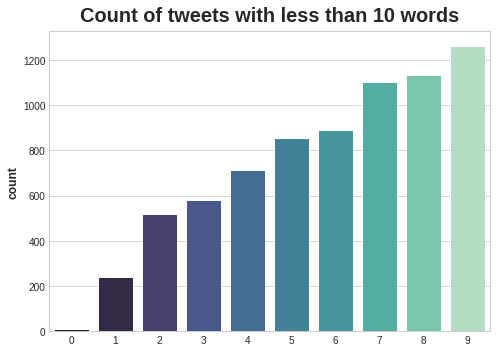

In [21]:
# Short tweets
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.ylabel('count')
plt.xlabel('')
plt.show()

Vamos remover tweets muito curtos (menos de 4 palavras)

In [22]:
#remover tweets curtos
df = df[df['text_len']>=4]

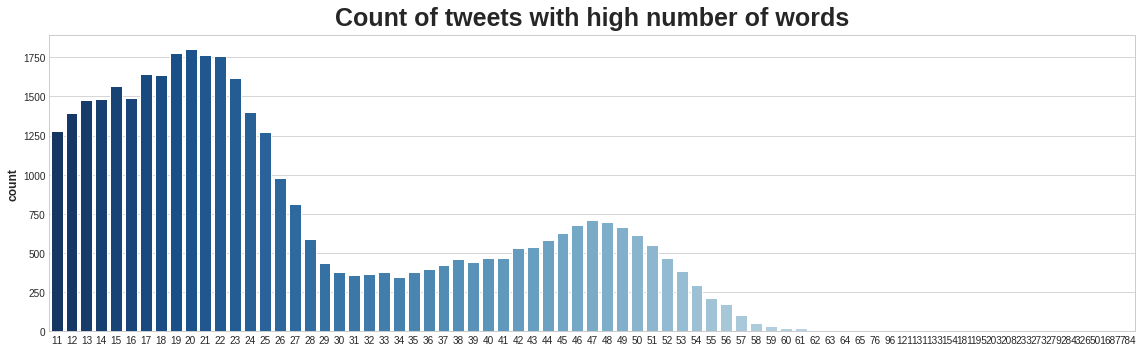

In [23]:
# Long tweets
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.ylabel('count')
plt.xlabel('')
plt.show()

Também vamos remover tweets muito longos (mais do que 100 palavras)

In [24]:
#Remover tweets longos
df = df[df['text_len']<=100]

In [25]:
# Extract max length
max_len = np.max(df['text_len'])
print(max_len)

96


É necessário realizar um encoding para a variável target.

In [26]:
# Encoding the target column: sentiment
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3, 'other_cyberbullying':4, 'not_cyberbullying':5})  # está correto a qtd de classes?

Separação do conjunto de dados em subconjuntos de treino, validação e teste.

In [27]:
# Splitting data into train and test subsets and then trian into train (again) and validation
X = df['text_clean']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [28]:
# target distribution
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5751],
       [   1, 5726],
       [   2, 5703],
       [   3, 5579],
       [   4, 4907],
       [   5, 5151]])

As classes não estão muito balanceadas, então vamos aplicar uma técnica de ______ para equilibrá-las.

In [30]:
tecnica = RandomOverSampler(random_state=seed_value)
X_train, y_train = tecnica.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment'])

In [31]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [32]:
# checking if classes are well balanced
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5751],
       [   1, 5751],
       [   2, 5751],
       [   3, 5751],
       [   4, 5751],
       [   5, 5751]])

## Modeling

In [ ]:
# function to print and plot confusion matrix
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Real', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

### Naive Bayes
Vamos implementar um modelo base utilizando o algoritmo Naive Bayes. Outros modelos também poderiam ser testados aqui, como Random Forest, Support Vector Machines etc.

In [ ]:
# create a bag of words with CountVectorizer()
clf = # ... seu código aqui
X_train_cv =  # ... seu código aqui
X_test_cv = # ... seu código aqui

In [ ]:
# apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).
tf_transformer = # ... seu código aqui
X_train_tf = # ... seu código aqui
X_test_tf = # ... seu código aqui

In [ ]:
# instantiate Naive Bayes model
nb_clf = # ... seu código aqui

In [ ]:
# train...
nb_clf.fit(X_train_cv, y_train)

In [ ]:
# and predict
nb_pred = nb_clf.predict(X_test_cv)

In [ ]:
report_naivebayes = classification_report(y_test, nb_pred, target_names=sentiments, output_dict=True)
print('Classification Report for Naive Bayes:\n', classification_report(y_test, nb_pred, target_names=sentiments))

In [ ]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

O modelo criado com o algoritmo Naive Bayes teve xxx desempenho, com acurácia geral de xxxxxx. Apesar do xxxx aplicado, a classe que originalmente apresentava menor representação nos dados foi a que teve xxxxx desempenho.

### Bidirectional LSTM
Da mesma forma que fizemos com Naive Bayes, precisamos pré-processar os dados. As frases serão convertidas em vetores numéricos com preenchimento (*padding*) para o número máximo de palavras em uma frase.

In [ ]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from text column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
        
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
vocabulary, tokenized_column = Tokenize(df['text_clean'], max_len)

In [ ]:
# example of the vectorized text
print('Original sentence:\n')
print(df['text_clean'].iloc[100])
print('\n Vectorized text:\n')
tokenized_column[100]

In [ ]:
# check the TOP 20 most common words
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
plt.ylabel("Words count")
plt.show()

#### Word Embedding by Word2Vec
Em seguida vamos utilizar um modelo pré treinado para criar uma matriz de representação numérica dos tweets. Anteriormente utilizamos a técnica Tf-idf. Agora utilizaremos a técnica Word2Vec.

In [ ]:
# text preparation
word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
# dimension of the vectors created by the method
EMBEDDING_DIM = # ... seu código aqui

In [ ]:
word2vec_model = # ... seu código aqui

In [ ]:
print(f"Vocabulary size: {len(vocabulary) + 1}")
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [ ]:
#define empty embedding matrix
embedding_matrix = # ... seu código aqui
    
#fill the embedding matrix with the pre trained values from word2vec
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
# use the tokenized sentences to create a training, validation and test datasets
X = tokenized_column
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:
# check the balance of the target classes
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

Dados desbalanceados. Novamente aplicaremos xxxxx.

In [ ]:
# ... seu código aqui

In [ ]:
# transform to tensor and prepare dataloaders to extract the data in batches for the LSTM training, validation and testing.
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [ ]:
BATCH_SIZE = # ... seu código aqui

In [ ]:
train_loader = DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

#### Modeling

In [ ]:
# Hyperparameters

# number of classes
NUM_CLASSES = # ... seu código aqui

# number of neurons of the internal state (internal neural network in the LSTM)
HIDDEN_DIM = # ... seu código aqui

#Number of stacked LSTM layers
LSTM_LAYERS = # ... seu código aqui

# Learning rate
LR = # ... seu código aqui

#LSTM Dropout
DROPOUT = # ... seu código aqui

#Boolean value to choose if to use a bidirectional LSTM or not
BIDIRECTIONAL = # ... seu código aqui

#Number of training epoch
EPOCHS = # ... seu código aqui

# set GPU if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

In [ ]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        # ... seu código aqui
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        # ... seu código aqui
        #LSTM LAYERS
        # ... seu código aqui
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

Agora vamos definir um loop de treinamento, onde incluímos uma funcionalidade *early stopping* e salvamos apenas os melhores modelos em termos de precisão de validação.

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []

    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0

    ###################################################################
    ###############        TRAINING LOOP         ######################
    ###################################################################

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        #get tensor of predicted values on the training set
        y_pred_train = torch.argmax(output, dim=1)

        #transform tensor to list and the values to the list
        y_train_list.extend(y_pred_train.squeeze().tolist()) 
        
        #count correctly classified texts per batch
        correct += torch.sum(y_pred_train==labels).item()
        
        #count total texts per batch
        total += labels.size(0) 

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)


    ###################################################################
    ##############        VALIDATION LOOP         #####################
    ###################################################################
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

In [ ]:
# LSTM Testing

model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [ ]:
report_bilstm = classification_report(y_test_list, y_pred_list, target_names=sentiments, output_dict=True)
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

In [ ]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

O modelo LSTM apresentou melhora significativa na performance. A acurácia geral xxxx para xx% e o numero geral de acertos também aumentou, especialmente na classe xxxxx.

### BERT

#### Train - validation - test split

In [ ]:
X = df['text_clean'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

Vamos aplicar o xx para balancear as classes

In [ ]:
# ... seu código aqui

In [ ]:
# ... seu código aqui

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

#### BERT Tokenization

A implementação do BERT da biblioteca Transformers possui seu próprio método de tokenização, que nos ajuda a extrair "*input ids*" e a "*attention mask*".

In [ ]:
tokenizer = # ... seu código aqui

Agora definimos a função para tokenização utilizando o tokenizador carregado acima.

In [ ]:
def bert_tokenizer(data, MAX_LEN):

    input_ids = []
    attention_masks = []
    
    for sentiment in data:
        encoded_sent = tokenizer.encode_plus(
            text=sentiment,
            add_special_tokens = True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length = max_len,             # Choose max length to truncate/pad
            pad_to_max_length = True,         # Pad sentence to max length 
            return_attention_mask = True      # Return attention mask
            )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Como precisamos especificar o comprimento da sentença tokenizada mais longa, tokenizamos os tweets do conjunto de treino usando o método "encode" do tokenizer BERT original e verificamos a sentença mais longa.

In [ ]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sentiment, add_special_tokens=True) for sentiment in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Vamos "arredondar" o max length...

In [ ]:
MAX_LEN = # ... seu código aqui

Agora aplicamos o tokenizador definido

In [ ]:
train_inputs, train_masks = bert_tokenizer(# ... seu código aqui
val_inputs, val_masks = bert_tokenizer(# ... seu código aqui
test_inputs, test_masks = bert_tokenizer(# ... seu código aqui

Então criaremos os dataloaders a partir dos arrays convertidos em tensores 

In [ ]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [ ]:
batch_size = # ... seu código aqui

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Agora podemos criar um classificador BERT personalizado, incluindo o modelo original e camadas densas adicionais para executar a tarefa de classificação.

In [ ]:
class Bert_Classifier(nn.Module):

    def __init__(self, n_input, n_hidden, n_output, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = n_input
        n_hidden = n_hidden
        n_output = n_output

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Add possibility to freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Além do classificador também vamos definir uma função para inicializar alguns parâmetros da rede.

In [ ]:
def initialize_model(epochs=4, lr=1e-3, eps=1e-6, n_input=768, n_hidden=50, n_output=5):

    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False, n_input=n_input, n_hidden=n_hidden, n_output=n_output)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=lr,      # learning rate, set to default value
                      eps=eps    # decay, set to default value
                      )
    
    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Utilizamos a GPU se estiver disponível para acelerar o processamento

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [ ]:
# BERT Parameters
n_input   = # ... seu código aqui
n_hidden  = # ... seu código aqui
n_output  = # ... seu código aqui
EPOCHS    = # ... seu código aqui
lr        = # ... seu código aqui
eps       = # ... seu código aqui

In [ ]:
#  intialize the BERT model calling the "initialize_model"
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS, lr=lr, eps=eps, n_input=n_input, n_hidden=n_hidden, n_output=n_output)

#### Training

In [ ]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # update model parameters
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [ ]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Agora definimos uma função para realizar as previsões com o BERT treinado.

In [ ]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to save the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [ ]:
# BERT predictions
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [ ]:
report_bert_reference = classification_report(y_test, bert_preds, target_names=sentiments, output_dict=True)
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

In [ ]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

O modelo BERT conseguiu resultados ainda melhores do que a rede Bi-LSTM, com f1-score superior para todos as classes, maior número de acertos geral e também por classes (com excessão da classe 'not bullyng') e melhora de 1 ponto percentual na acurácia.

# Avaliação

Não altere as células a seguir, apenas as execute

In [5]:
# Valores Base e Referência obtidos anteriormente
br = 0.95
lr = 0.93
nr = 0.86

bb = 0.60
lb = 0.33
nb = 0.77

In [ ]:
# Valores obtidos pelo aluno

ba = round(report_bert['accuracy'], 2)
la = round(report_bilstm['accuracy'], 2)
na = round(report_naivebayes['accuracy'], 2)

ba, la, na

In [6]:
# Exemplo de valores obtidos pelo aluno
#ba, la, na = .8, .8, .8

[]

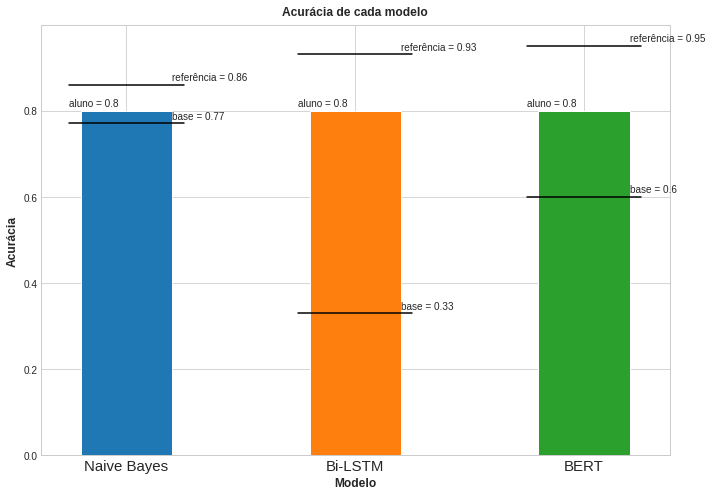

In [7]:
plt.figure(figsize=(10 , 7))

# results_   = [base, referencia, aluno]
results_bert = [bb, br, ba]
results_lstm = [lb, lr, la]
results_naiv = [nb, nr, na]

xcol = 1

for rm in [results_naiv, results_lstm, results_bert]:
    rb = rm[0]
    rr = rm[1] 
    ra = rm[2]

    plt.bar(xcol + 0.5, ra)
    plt.annotate(f'aluno = {ra}', xy=[xcol , ra + 0.01], fontsize=10)

    plt.annotate(f'base = {rb}', xy=[xcol + 0.9, rb + 0.01], fontsize=10)
    plt.plot([xcol, xcol+1], [rb, rb], color='black')

    plt.annotate(f'referência = {rr}', xy=[xcol + 0.9, rr + 0.01], fontsize=10)
    plt.plot([xcol, xcol+1], [rr, rr], color='black')

    xcol += 2

plt.xticks([1.5, 3.5, 5.5], ['Naive Bayes', 'Bi-LSTM', 'BERT'], fontsize=15)

plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Acurácia de cada modelo')

plt.plot()

0.6


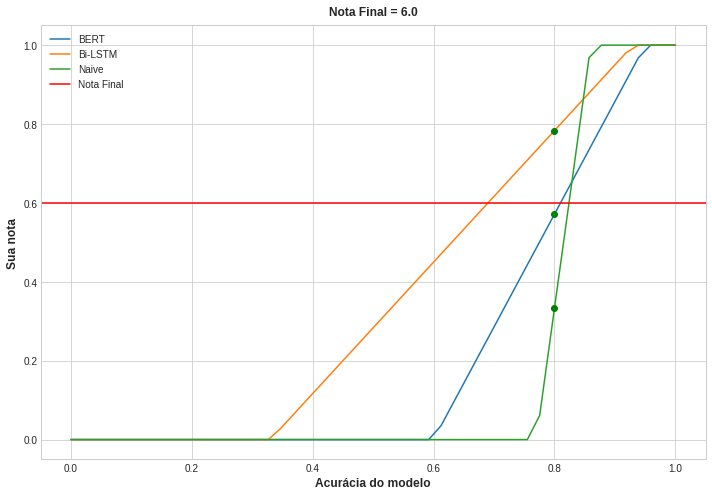

In [8]:
plt.figure(figsize=(10, 7))

x = np.linspace(0, 1)

# valores base e referencia
plt.plot(x, nota(bb, br, x), label='BERT')
plt.plot(x, nota(lb, lr, x), label='Bi-LSTM')
plt.plot(x, nota(nb, nr, x), label='Naive')

# nota do aluno
nota_bert = nota(bb, br, ba)
nota_lstm = nota(lb, lr, la)
nota_naive = nota(nb, nr, na)

plt.plot(ba, nota_bert, 'go')
plt.plot(la, nota_lstm, 'go')
plt.plot(na, nota_naive, 'go')

nota_final = round((nota_bert + nota_lstm + nota_naive) / 3, 1)
print(nota_final)
plt.axhline(nota_final, color='r', label='Nota Final')

plt.legend()
plt.ylabel('Sua nota')
plt.xlabel('Acurácia do modelo')
plt.title(f'Nota Final = {nota_final*10}')

plt.show()